<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow-probability

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [0]:
tf.enable_eager_execution()

In [0]:
tfe = tf.contrib.eager
tfd = tfp.distributions
ed = tfp.edward2

### データの生成
ある少数の成分はただのガウスノイズ。ほかはsin波形かcos波形であるような多次元信号を生成します。このような設定にしていることには意味があるので、覚えておいてください。


In [0]:
def toy_data(N, D):
    t = np.linspace(-np.pi, np.pi, N)
    def random_choice_wave():
        random_value = np.random.randn()
        if random_value < -0.9:
            ## ガウスノイズを発生
            return lambda x: 0.2*np.random.randn(N)
        elif random_value < 0.4:
            return np.cos
        else:
            return np.sin
    X = [random_choice_wave()(2*np.pi*t)+0.2*np.random.randn(N) for _ in range(D)]
    return np.array(X).transpose(1, 0)

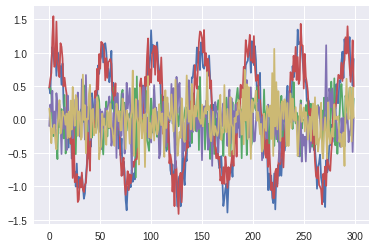

In [40]:
X = toy_data(300, 5)
plt.plot(X)

### 主成分分析
平均が$0$になるように座標の平行移動が行われた後の観測データ を$\bf x_i \in \mathcal R^D $とします（この作業は単に成分毎に平均を求めてデータから減産すれば良い）。このデータを並べた行列を $\bf X = (x_1, \cdots, x_N)^T$ としましょう（すなわち $\bf X \in \mathcal R^{N\times D}$となっています）。主成分分析は観測データの分散共分散行列 $\bf V_x = X^T X \in \mathcal R^{D\times D}$ を固有値分解することで実施することができます。分散共分散行列は対称行列なので、適当な直交行列 $\bf U$ を使って、

$$
\bf V_x = U\Lambda U^T
$$
 
と固有値分解できます。ここで $\bf \Lambda =diag(\lambda_1,\cdots ,\lambda_D) $ です。$\lambda_i$は固有値です（縮退も含めれば次元の数 $ D$だけ得られます）。

In [0]:
X = tf.convert_to_tensor(X, dtype=tf.float32)
V_x = tf.matmul(tf.transpose(X), X)
Lam, U = tf.linalg.eigh(V_x)

#### 固有値は射影先での分散
ココまでは主成分分析の解法を見ただけであり、データの意味として何が求まっているのかについて言及していません。さて、ここで求まった固有値とは一体何でしょうか。それをちゃんと理解するために数式をちゃんと見てみましょう。

$$
\bf V_x = U\Lambda U^T
$$

という固有値分解をしたのでしたが、$\bf V_x = X^TX$だったことを思い出しましょう。こいつをしっかり意識してやれば、

$$
\begin{align}
&&\bf V_x = &\bf U\Lambda U^T \\
\Leftrightarrow&& \bf X^TX = &\bf U\Lambda U \\
\Leftrightarrow&& \bf U^TX^TXU = &\Lambda \\
\Leftrightarrow&& \bf (XU)^TXU = &\Lambda \\
\Leftrightarrow&& \bf Z^TZ = &\Lambda \\ 
\end{align}
$$

と変形できます（ $\bf Z = \bf XU $と置きました ）。これは要するに $\bf X$ を $\bf U$ で変換してやって、$\bf Z$ の座標で見てやったときには、各成分が無相関になっており、各成分の分散がは$\Lambda$ の対角成分に格納されているということを意味しています。なぜならこの座標では分散共分散行列$\bf V_z = Z^TZ$ が対角行列 $\bf \Lambda$ となっているためです。

In [42]:
## TFでは小さい順に固有値を返してくるようだ
print(Lam)

tf.Tensor([ 14.230406  21.491524  23.256502  27.719532 319.18292 ], shape=(5,), dtype=float32)


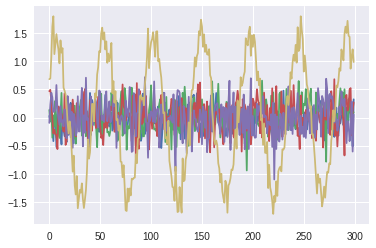

In [43]:
## 固有値の大きな3つの成分だけを見てみる
Z = tf.matmul(X, U[:, :])
plt.plot(Z.numpy())

#### 解釈
元々の信号は、殆どの成分がsin波（に小さなガウスノイズが乗ったもの）か、あるいはcos波（に小さなガウスノイズが乗ったもの）でした。sin波とcos波は互いに統計的に無相関になりますし、ガウスノイズとsin波（あるいはcos波）も無相関です。
すなわち、生成された多次元信号 $\bf X$ に関しては相関があるのは sin 波同士か、 cos 波同士しかありえません。主成分分析で無相関化された $\bf Z$ という多次元信号は元々相関があった信号をとある1つの成分に寄せ集めたものです。

すなわち、ある成分には sin 波が、ある成分には cos波 が集められ、そしてその2つの成分を除けば後は全て雑多な信号になっているはずです。当然、相関を持った信号が寄せ集められた結果、振幅は大きくなります。すなわち、その成分の分散は大きくなるということです。

このように意味のある信号がある成分に大きな分散を持って寄せ集まると信じれば（あるいはそのような性質の多次元信号を扱っているのであれば）、主成分分析での次元削減は有意義なものとなります。

　

#### 一般の場合
実際には $\bf X$ が時系列信号を並べた多次元信号で無くてもいいです。そもそも最初から画像のように $\bf X$という行列の形式を取ったデータでも構いません。画像を扱うならば、画像を縦に区切って各列を信号の如く扱い、他の列と相関がある列を寄せ集めて1つの列に集めているというイメージをすればいいです。

もし意味のある画像の列が主成分分析で保持できるとするならば、$\bf Z$という列を減らした画像（のようなもの）から再度 $\bf X$ を構築すれば、オリジナルの画像を良い精度で再構成できるはずです（逆に言えば$\bf Z$という容量の小さなデータで十分かもしれないということ） 。

ただし、無理に信号と絡める必要はありません。主成分分析は 行列$\bf X$ のユニタリ不変ノルムを最小化するという意味での低ランク近似としても定式化できます。ただ、そのような手順を取ったとしてもフロベニウスノルム最大化という観点で、特異値と固有値の関係（ $\bf X$ の特異値分解 と $\bf X^T X$の固有値分解の関係 ）を通して、今回の理解が必ず役立つでしょう。


### 無相関化されていることを見る
より一般的な多次元データを扱います。$\bf X \in \mathcal R^{N\times D}$ としましょう。この今回は $N = 300$ , $D = 10$ でやってみて、変換先のデータを見てみましょう。

In [0]:
def toy_scatter(N, D):
    W = np.random.randn(D, D)
    X = np.random.randn(N, D)
    return X @ W
X = toy_scatter(N=300, D=5)

#### 正の相関、負の相関、いろいろ見られる

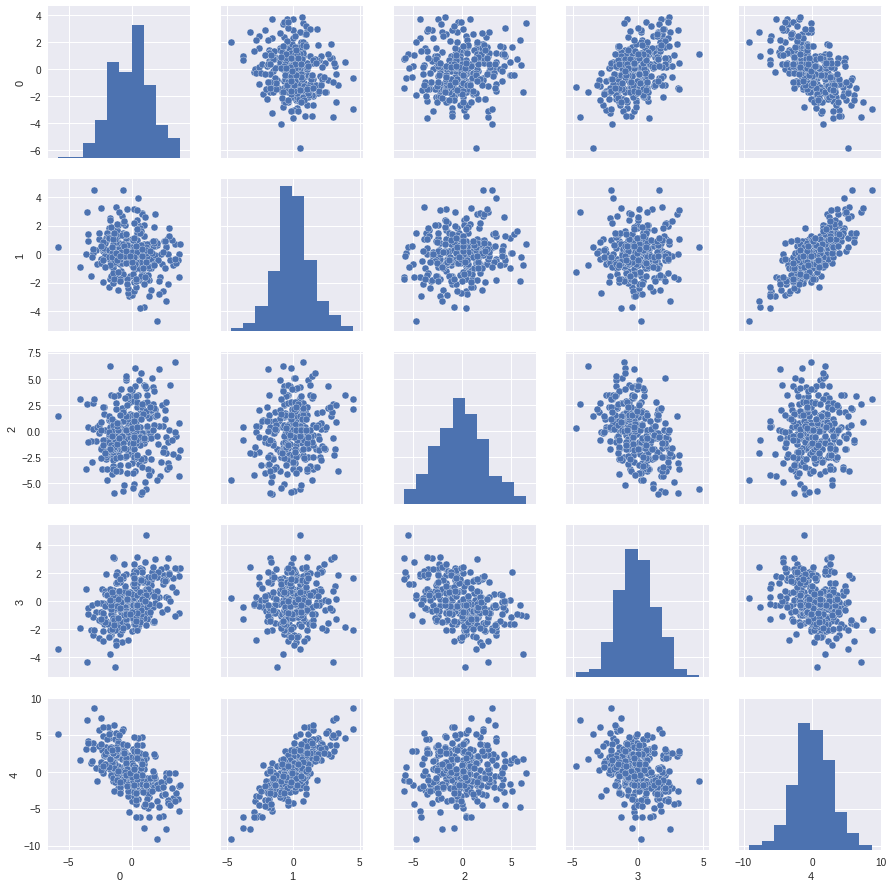

In [12]:
sns.pairplot(pd.DataFrame(X))

In [0]:
X = tf.convert_to_tensor(X, dtype=tf.float32)
V_x = tf.matmul(tf.transpose(X), X)
Lam, U = tf.linalg.eigh(V_x)

#### 確かに無相関化されている
TFの固有値分解は固有値が小さい順に並んでいることに注意しつつ、データが無相関化されていることに加えて、分散の大きさが明らかに異なっていることも把握しましょう。通常は分散が小さな成分は切り捨ててしまいます。

tf.Tensor([  95.56116  299.81702 1314.9426  2136.445   3917.3164 ], shape=(5,), dtype=float32)


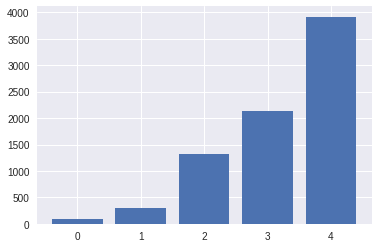

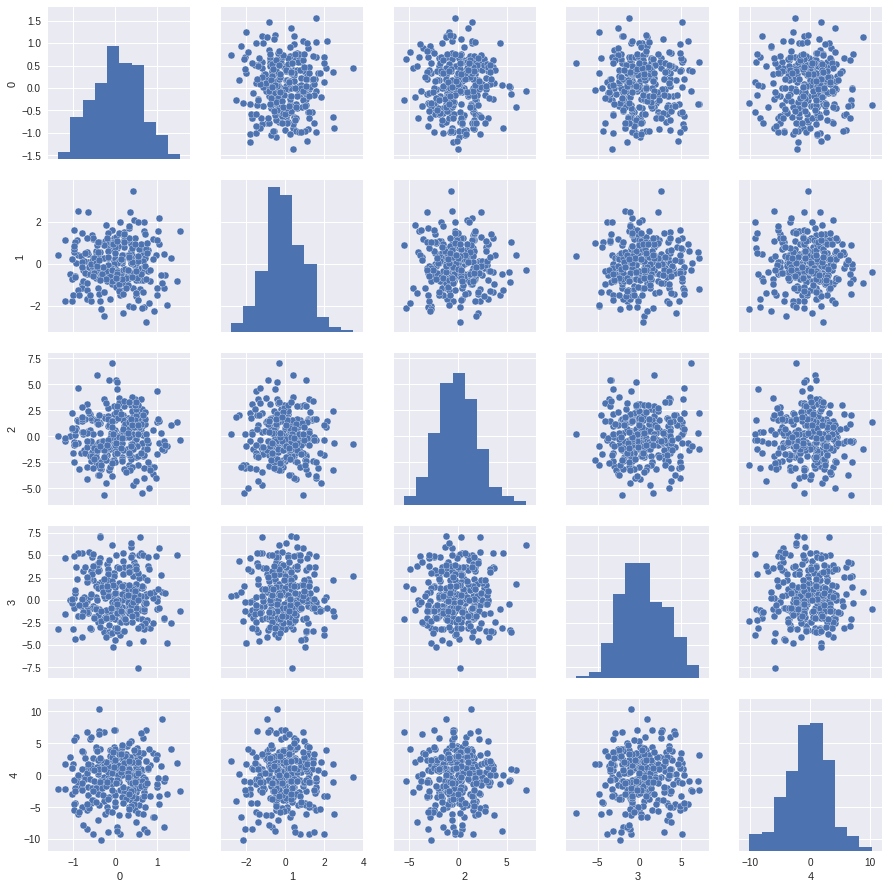

In [58]:
print(Lam)
plt.bar(x=[0, 1, 2, 3, 4], height=Lam)
Z = tf.matmul(X, U[:, :])
sns.pairplot(pd.DataFrame(Z.numpy()))

### 確率的主成分分析
確率的主成分分析では、潜在変数 $\bf z \in \mathcal R^M$ があり、こちらが線形変換 $\bf W$ を受けて $\bf x \in \mathcal R^D$ になって私達の目に入る（観測する）という問題設定になります。また、この観測をするときには、$ \sigma^2$ の当方的分散をもつガウス分布としてバラツくと考えます。

$$
\bf x \sim \mathcal N\bf (Wz, \sigma^2I)
$$

潜在変数$\bf z$ はどこからやってくるのかというと、平均 $\bf 0$、分散 $\bf I$の当方的分散を持つガウス分布から生起していると考えます。すなわち

$$
\bf z \sim \mathcal N \bf (0, I)
$$

です。ここでパラメータ$\bf W$を最尤推定するのが確率的主成分分析です。確率的主成分分析では、$\bf z$に関して周辺化を行った確率分布について最尤推定を実施します。

$$
p({\bf x}\mid {\bf W,z}, \sigma) = \mathcal N\bf (Wz, \sigma^2I)
$$

であるのですが、 $p({\bf z})=\mathcal N \bf (0, I)$であることを使って下記のように周辺化を実施します。

$$
p({\bf x} \mid {\bf W}, \sigma) = \int_{\bf z} \mathcal N {\bf (Wz, \sigma^2I)} \mathcal N  (0, I) d{\bf z}
$$

こいつの計算結果は

$$
p({\bf x} \mid {\bf W}, \sigma) =\mathcal N {\bf (0, WW^T  + \sigma^2I)}
$$

となります。この分布に関して最尤推定を行えば $\bf W$の解が得られるというわけです。具体的には $D = \{{\bf x}_1,\cdots, {\bf x}_N  \}$が実際に手元に入る確率は、上記の $p({\bf x}_n \mid {\bf W}, \sigma)$ が $n= 1, \cdots, N$ に関して起こり続けた場合の確率であり、下記で表されます。

$$
\prod_{n=1}^{N} p({\bf x}_n \mid {\bf W}, \sigma)
$$

これを尤度関数と呼び、$\bf W$ について最大化を行えばいいです。このままではかなり扱いにくいので、例のごとく対数尤度を最大化することに問題をすり替えます（対数関数は単調増加かつ、元の関数と極値が同じなので問題ありません）。ちなみに、これは解析的に求まります（ただし、$\bf W$の直交行列による変換の任意性を残すことになります）。

In [0]:
x_train = tf.cast(X, dtype=tf.float32)
data_dim = x_train.shape[1]
num_datapoints = x_train.shape[0]


class PPCA(tf.keras.Model):
    def __init__(self, latent_dim=5, stddv_datapoints=0.5):
        super(PPCA, self).__init__()
            
        self.latent_dim = latent_dim
        self.stddv_datapoints = 0.5
            
        self.W = tf.Variable(
            0.1 * tf.random_normal(shape=[latent_dim, data_dim]), 
            dtype=tf.float32)

        self.z = tf.Variable(
            np.ones([num_datapoints, latent_dim]), 
            dtype=tf.float32)
        
        self.data_dim = None
    
    
    def _data_dim(self, x):
        self.data_dim = tf.constant(x.shape[1])
    
    @staticmethod
    def _calc_Vx(x):
        N = tf.constant(x.shape[0], dtype=tf.float32)
        return (1/N) * tf.transpose(x) @ x
        
    
    def _calc_C(self):
        return (
            tf.transpose(self.W) @ self.W
            + self.stddv_datapoints ** 2 * tf.eye(tf.constant(self.data_dim))
        )

    def _calc_M(self):
        return (
            self.W @ tf.transpose(self.W)
            + self.stddv_datapoints ** 2 * tf.eye(tf.constant(self.latent_dim))
        )
    
    def _calc_invC(self):
        M = self._calc_M()
        return (
            self.stddv_datapoints ** (-2) * (
                tf.eye(tf.constant(self.data_dim))
                - tf.transpose(self.W) @ M @ self.W
            )**(0.5)
        )
    
    def train(self, x):
        Vx = self._calc_Vx(x)
        Lam, U = tf.linalg.eigh(Vx)
        W_ml = (
            U[:, -self.latent_dim:] @ (
            tf.linalg.diag(Lam[-self.latent_dim:]) 
            - self.stddv_datapoints**2 * tf.eye(tf.constant(self.latent_dim))
            )
        )
        self.W = tf.transpose(W_ml)
    
    def call(self, x):     
        return (
            tf.matmul(x, tf.transpose(self.W))
            @ tf.linalg.inv(self._calc_M())
        )
    
    def generate_x(self, num_samples=100):
        dist = tfd.MultivariateNormalFullCovariance(
            loc=tf.zeros(shape=[self.data_dim]),
            covariance_matrix=self._calc_C()            
        )
        return dist.sample(num_samples)

        
    

In [0]:
with tf.device("gpu:0"):
    model = PPCA(latent_dim=5) 
    model._data_dim(x_train)

#### 初期値がいい加減なので射影もいい加減です
試しに全く学習していない $\bf W$ で射影してみましょう。

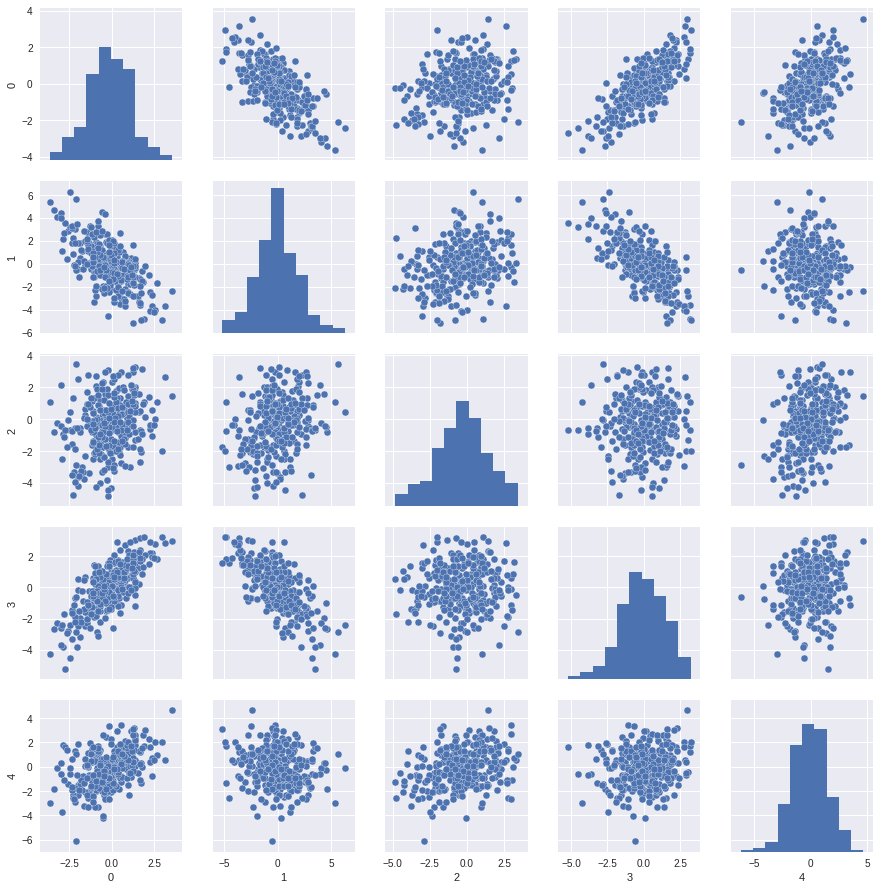

In [65]:
z_initial = model(x_train)
sns.pairplot(pd.DataFrame(z_initial.numpy()))

#### 学習後は潜在変数の空間では無相関

In [0]:
model.train(x_train)

In [0]:
z = model(x_train)

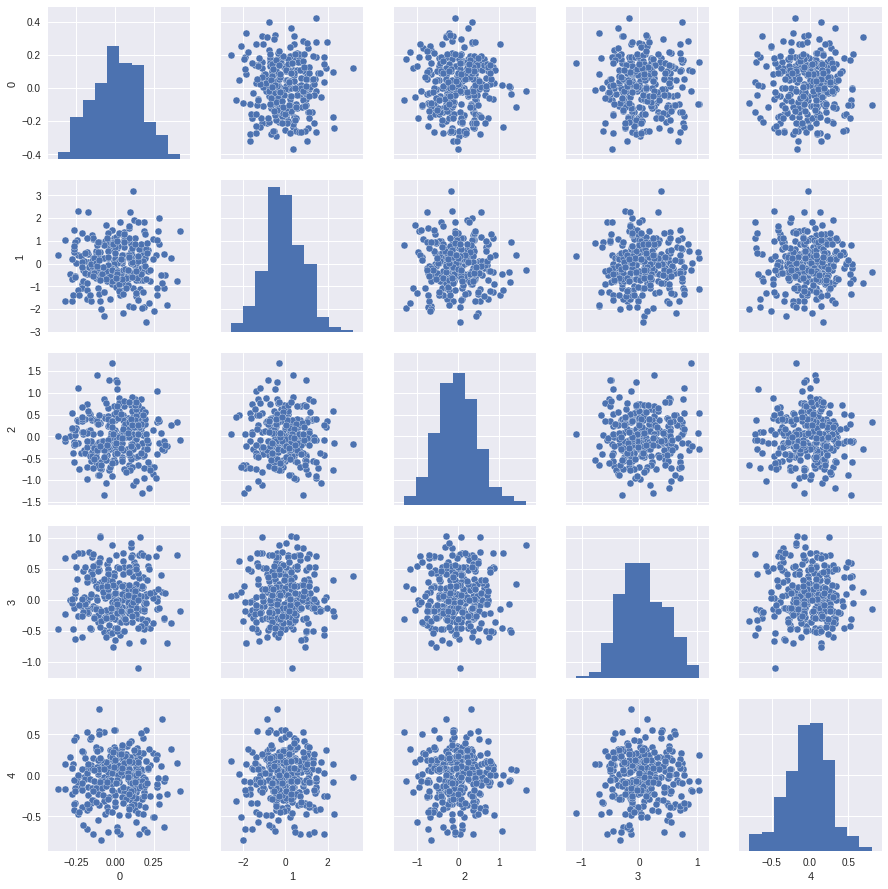

In [68]:
sns.pairplot(pd.DataFrame(z.numpy()))

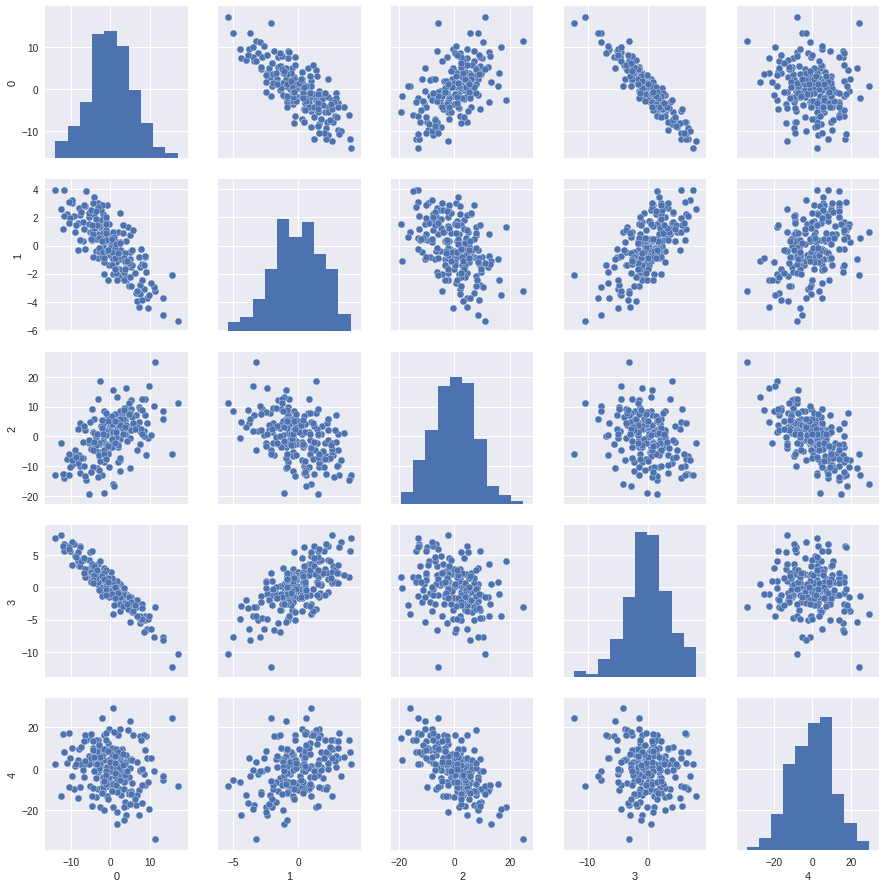

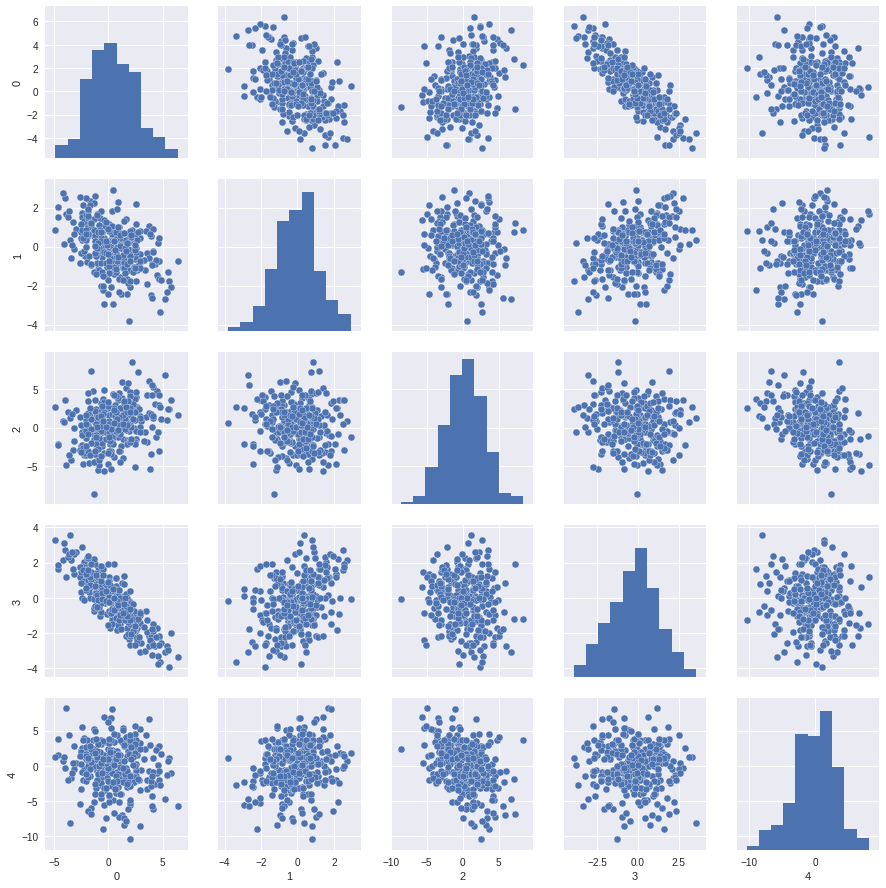

In [70]:
x_generated = model.generate_x(200)
sns.pairplot(pd.DataFrame(x_generated.numpy()[:, :]))
sns.pairplot(pd.DataFrame(x_train.numpy()[:, :]))

### ベイズ主成分分析
ベイズ主成分分析では最尤推定時にパラメータとして点推定した $\bf W$の方も何らかの確率分布位から発生していると考えます。

また、確率変数 $x$ が確率分布がガウス分布 $\mathcal N(\mu, \sigma^2)$から生起することを明記するために $\mathcal N(x\mid \mu, \sigma^2)$ などと表現します。より一般的には $p(x \mid \theta_1, \theta_2, \cdots)$ などと書かれたりします。

さて、ベイズ主成分分析の問題設定の一例は下記のようになります。

$$
\begin{align}
\bf x & \sim \mathcal N\bf (x \mid Wz, \sigma^2I) \\\
\bf z & \sim \mathcal N \bf (z \mid 0, I)\\\
\bf W & \sim \prod_i^D \prod_j^M \mathcal N ( w_{ij} \mid 0, \sigma^2)
\end{align}
$$

ここで $w_{ij}$ とは $\bf W$ の $(i,j)$ 成分です。すなわち上の設定では、「$\bf W$ の各成分が独立にガウス分布から生起している」という事前確率分布を考えたことになります。

#### 補足
事前分布はモデルの設計者が自ら考えれば良いものであり、任意性があります。他にも、$\bf W$ の各縦ベクトル ${\bf w}_i$ 毎に多次元正規分布を事前確率に選ぶなどの方法もあります。具体的にはPRMLでは、

$$
{\bf W} \sim  \prod_{i=1}^M \left(\frac{\alpha_i}{2\pi} \right)^{D/2} \exp\left(-\frac{1}{2}\alpha_i {\bf w}_i^{\bf T} {\bf w}_i\right)
$$

を使う方法などが書かれています。


### ベイズ学習で得るもの
さて、一旦ベイズ学習の基本的な話をします。確率的主成分分析の最尤推定では尤度関数を最大化することで$\bf W$をただ1つ求めていました（そしてそれは解析的に求められるのでした）。ベイズ主成分分析では $\bf W$ をただ1つに求めるのではなく、観測データ $D = \{{\bf x}_1, {\bf x}_2, \cdots, {\bf x}_N\}$ からみた場合には $\bf W$ はこれくらいだろうなということを表す事後分布 $p({\bf W} \mid D)$ を求めます。

これはベイズ主成分分析がというわけではなく、ベイズ学習全体に共通して言えることです。線形回帰でもロジスティック回帰でも、点推定していたパラメータ$\bf W$を確率変数だと考え、そして持ちうる観測データ $D $ から分布を推論します。この事後分布は条件付き分布と同時分布の関係から簡単に下記のように求まります。

$$
p({\bf W} \mid D) = \frac{p(D \mid {\bf W})p({\bf W})}{p(D)}
$$

右辺の分子はすでに検討し終わっている「尤度関数」と「事前分布」によって構成されており、分母に関しては色々な呼び名がありますが、確率の体裁を整えるための正規化定数だと思っておいてください（汎化誤差の議論をしたい場合には、個々の部分は結構主役級の存在感を示しますが、学習を実行する段階では特に意識しなくても問題ないです）。

#### 補足1
事後分布を求める場合において、
これをうまく求めるためには、尤度関数や事前分布を上手に設計する必要（共役事前分布を使うなど）がありましたが、現在はコンピュータの力で近似を実行できるようになってきました。うまく手計算がしやすいようにモデルを設計して行く必要は、今の環境ではそれほど重要ではなく、ちゃんとデータを表すモデルを設計することが大事になります。


#### 補足2
データ $D$ から「何の」事後分布を求めたいのかは問題によることに注意してください。いつでも観測データを手に入れる手順を確率分布で記述し（生成モデルを記述し）、あとは同時分布と条件付き分布の関係や周辺化などのテクニックで欲しい事後分布を書き下すというのが一連の流れです。

In [0]:
def toy_model(N, data_dim, latent_dim, scale):
    z_rv = tfd.Normal(loc=tf.zeros([latent_dim]),
                      scale=tf.ones([latent_dim])).sample(200)
    W_rv = tfd.Normal(loc=tf.zeros([latent_dim, data_dim]),
                      scale=tf.ones([latent_dim, data_dim])).sample()
    x_rv = tfd.Normal(
        loc=tf.matmul(z_rv, W_rv),
        scale=scale
    ).sample()
    return x_rv

In [0]:
N = 200
data_dim = 5
latent_dim = 3
scale = 0.5
x_train = toy_model(N, data_dim, latent_dim, scale)

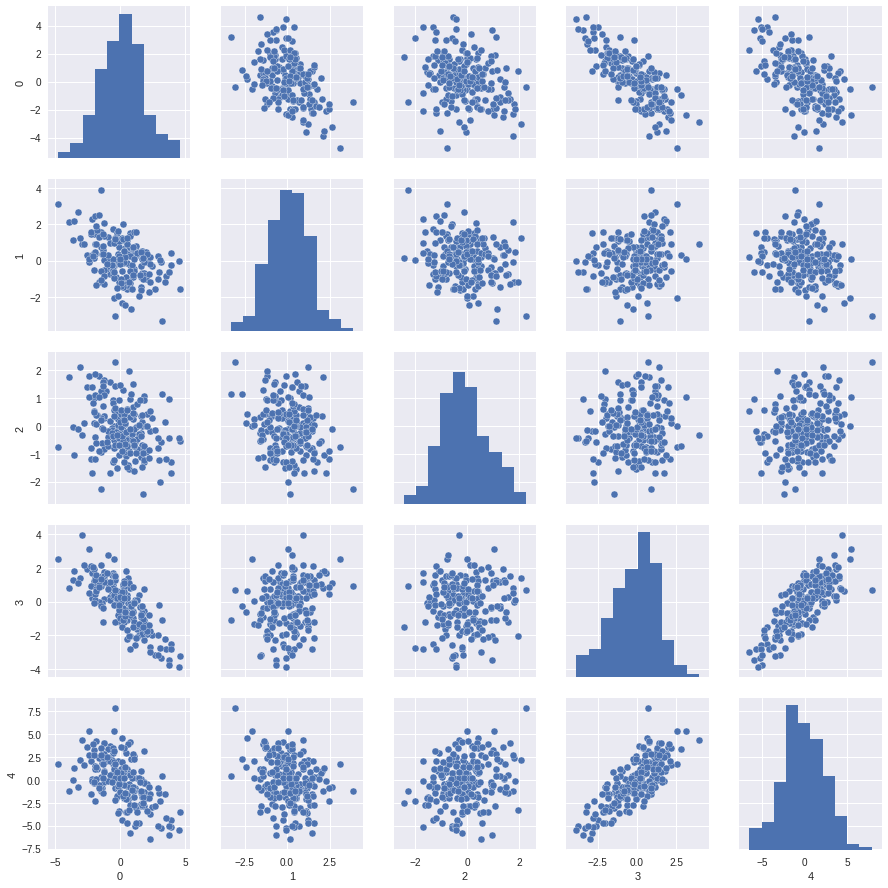

In [30]:
sns.pairplot(pd.DataFrame(x_train.numpy()))

#### MAP推定
事後分布を最大化する点推定です。ベイズ推論で事後分布を求めることを諦めた場合（分布の形はわからないが、最大値になるかは勾配法で分かる）の策です。「諦めた」という表現は、もしも事後分布を求めることができれば最大値と最大となる点は分かるにもかかわらず、全体を把握することをやめた。という意味であり、それが分析対象にとっては必要十分である場合も多々あるので、「悪い」という意味ではありません。

もしも無情報事前分布を使う場合はMAP推定と最尤推定は何も違いがありません。

In [0]:
z_var = tf.Variable(tf.random_normal([N, latent_dim]))
W_var = tf.Variable(tf.random_normal([latent_dim, data_dim]))

def joint_log_prob(x, z, W):
    z_rv = tfd.Normal(loc=tf.zeros([N, latent_dim]),
                      scale=tf.ones([N, latent_dim]))
    
    W_rv = tfd.Normal(loc=tf.zeros([latent_dim, data_dim]),
                      scale=tf.ones([latent_dim, data_dim]))
    x_rv = tfd.Normal(
        loc=tf.matmul(z, W),
        scale=0.5
    )
    return (
        tf.reduce_mean(tf.reduce_sum(x_rv.log_prob(x), axis=1)) +
        tf.reduce_mean(tf.reduce_sum(z_rv.log_prob(z), axis=1))+
        tf.reduce_sum(W_rv.log_prob(W))
    )

In [0]:
loss = lambda z, W: - joint_log_prob(x_train, z, W)
optimizer = tf.train.AdamOptimizer()

In [0]:
grads_and_value = tfe.implicit_value_and_gradients(loss)

In [67]:
for i in range(1000):
    loss, grads = grads_and_value(z_var, W_var)
    optimizer.apply_gradients(grads)
    if i % 100 == 0:
        print("loss{}: {}".format(i, loss.numpy()))

loss0: 28.792766571044922
loss100: 28.365766525268555
loss200: 27.97393798828125
loss300: 27.61599349975586
loss400: 27.290855407714844
loss500: 26.997241973876953
loss600: 26.73342514038086
loss700: 26.497150421142578
loss800: 26.28570556640625
loss900: 26.096031188964844


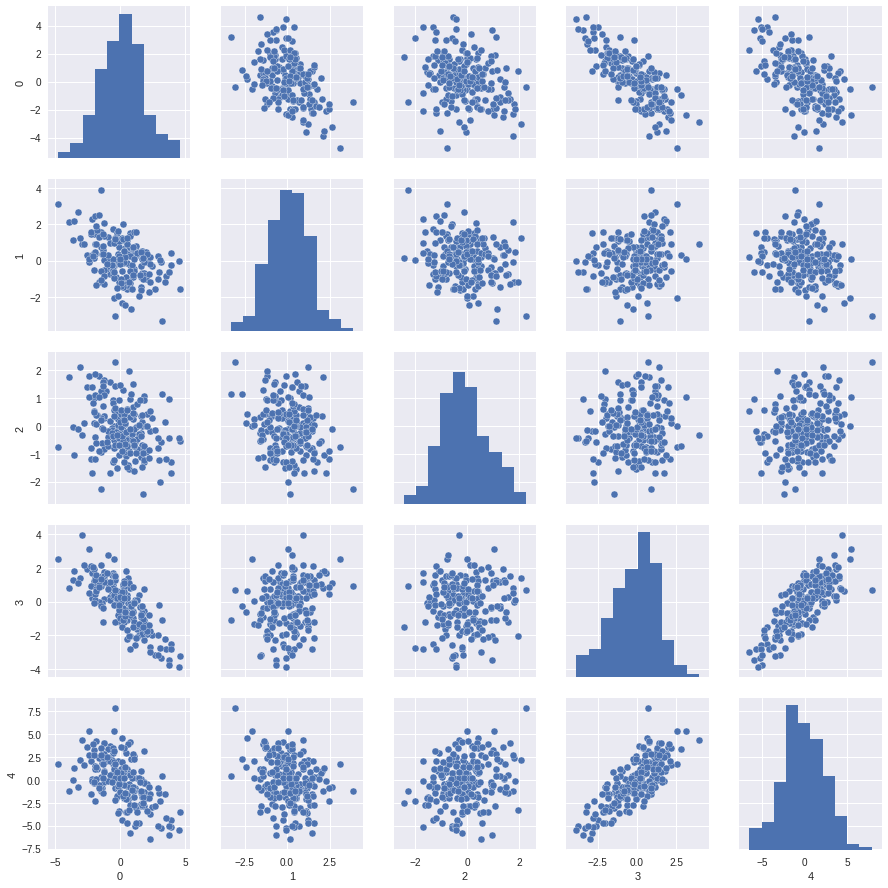

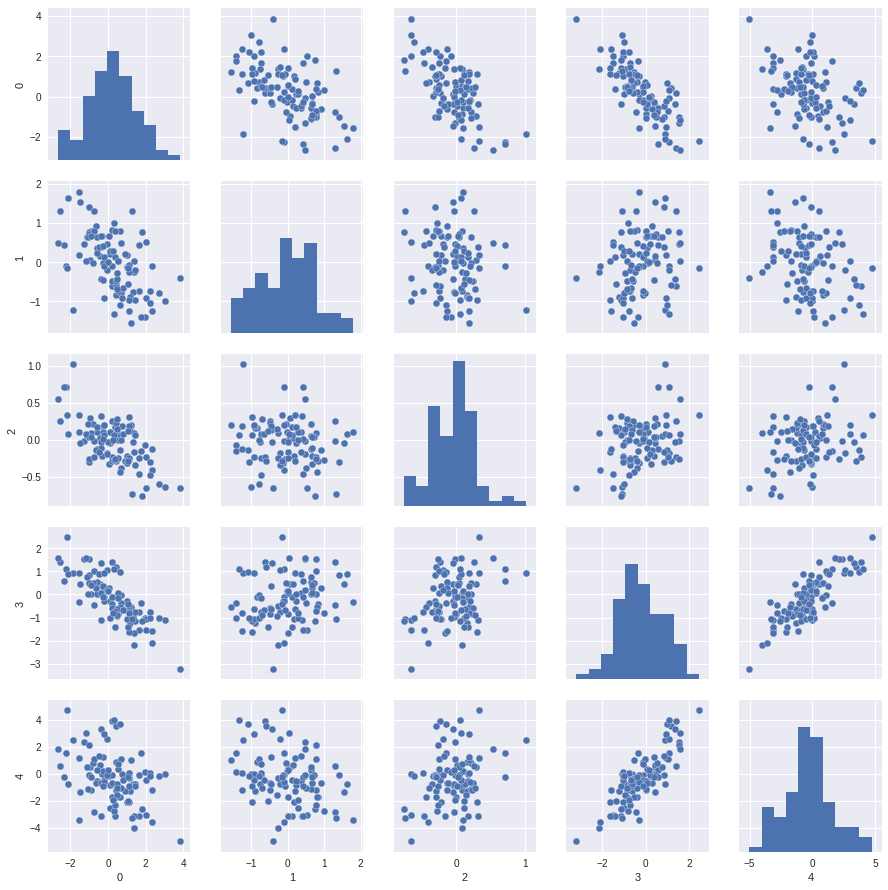

In [73]:
sns.pairplot(pd.DataFrame(x_train.numpy()))
x_generated = tf.matmul(tf.random_normal([100, latent_dim]), W_var)
sns.pairplot(pd.DataFrame(x_generated.numpy()))

###変分ベイズ主成分分析
ここでは一歩進めてベイズ主成分分析を見ましょう。$\bf W$に事前分布を適当に敷くことで、ベイズ主成分分析へと発展させられます。例えばPRMLでは下記のように事前分布を置く方法を紹介しています。

$$
{\bf W} \sim  \prod_{i=1}^M \left(\frac{\alpha_i}{2\pi} \right)^{D/2} \exp\left(-\frac{1}{2}\alpha_i {\bf w}_i^{\bf T} {\bf w}_i\right)
$$

ここで、${\bf w}_i$ は $\bf W$の $i$番目の列ベクトルです（すなわち${\bf W} = ({\bf w}_1, \cdots, {\bf w}_i, \cdots, {\bf w}_M )$である）。また $\bf W \in \mathcal R^{D\times M} $となっていることに注意してください。これは各列ベクトルが独立の異なるガウス分布から生起しているという問題設定です。更に周辺尤度最大化によるフルベイズでハイパーパラメータ$\alpha_i$の決定を行うこともでき、PRMLではEMアルゴリズムによってこれを導出しています。$\alpha_i$が非常に小さな値となれば、そのインデックス$i$に相当する${\bf w}_i$は自動で $0$ なるため、次元削減のために $M < D$ と選ばなくとも次元削減を行うことが可能です。

#### 今回の問題設定
今回はあまり小難しい推論は行わずに、下記のように適当な事前分布を敷いてしまいます。

$$
w_{dm} \sim \mathcal N(0, 4)
$$

ここで、$\bf W$の $d$ 行$ m$ 列の成分を $w_{dm}$ とします。要するに全部の成分が独立に分散 $4$ のガウス分布から生起しているという問題設定です。ちなみに、各成分がこのガウス分布から生起しているというのはかなり緩い事前分布です。なぜなら、$\bf W$ が直交行列であるだろうという主成分分析の背景を知っている我々にとって、各成分は$1$ 未満の小数点になっていると分かりきっていることだからです。それをわざわざ分散 $4$ の幅を持たせていることは無情報事前分布に等しいといえます。


In [0]:
x_train = tf.cast(X, dtype=tf.float32)
data_dim = x_train.shape[1]
latent_dim = 3
num_datapoints = x_train.shape[0]

def model_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = ed.Normal(loc=tf.zeros([latent_dim, data_dim]),
                scale=2.0 * tf.ones([latent_dim, data_dim]),
                name="w")  # parameter
    z = ed.Normal(loc=tf.zeros([num_datapoints, latent_dim]),
                scale=tf.ones([num_datapoints, latent_dim]), 
                name="z")  # parameter
    x = ed.Normal(loc=tf.matmul(z, w),
                scale=stddv_datapoints * tf.ones([num_datapoints, data_dim]),
                name="x")  # (modeled) data
    return x, (w, z)

log_joint = ed.make_log_joint_fn(model_pca)

def target(w, z):
    """Unnormalized target density as a function of the parameters."""
    return log_joint(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints,
                   w=w, z=z, x=x_train)

In [0]:
def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
    qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
    return qw, qz

log_q = ed.make_log_joint_fn(variational_model)

def target_q(qw, qz):
    return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
               qz_mean=qz_mean, qz_stddv=qz_stddv,
               qw=qw, qz=qz)


In [0]:
qw_mean = tf.Variable(tf.random_normal([latent_dim, data_dim]), dtype=tf.float32)
qz_mean = tf.Variable(tf.random_normal([num_datapoints, latent_dim]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, data_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([num_datapoints, latent_dim]), dtype=tf.float32))

qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                           qz_mean=qz_mean, qz_stddv=qz_stddv)


def elbo_minus(qw, qz):    
    energy = target(qw, qz)
    entropy = -target_q(qw, qz)
    return -(energy + entropy)

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate = 0.5)
loss_and_grads = tfe.implicit_value_and_gradients(elbo_minus)

In [0]:
for i in range(1000):
    loss, grads = loss_and_grads(qw, qz)
    optimizer.apply_gradients(grads)
    if i % 100 == 0:
        print(loss.numpy())

-871408860000.0
-1046387700000.0
-1235204800000.0
-1437437800000.0
-1652693900000.0
-1880606200000.0
-2120831900000.0
-2373051500000.0
-2636966000000.0
-2912302400000.0


In [0]:
qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                           qz_mean=qz_mean, qz_stddv=qz_stddv)

In [0]:
qw

<ed.RandomVariable 'qw/' shape=(3, 5) dtype=float32 numpy=
array([[-1517.6908, -1516.2698, -1517.3226, -1518.3171,  1517.3431],
       [ 1519.5204, -1519.1212,  1518.4124, -1517.037 , -1517.3748],
       [ 1517.5997,  1517.9011, -1518.5743,  1518.1221,  1516.9664]],
      dtype=float32)>

#### MAP推定
まずはMAP推定をしましょう。事後分布を最大化するようなパラメータを求めれば、MAP推定の完了です。事実上はやることとして最尤推定とさして代わりません（ただし観測データに依存しない事前分布の尤度に最適化が引っ張られるため、正則化の効果がある）。



In [0]:
data_dim = X.shape[1]
# print(data_dim)
latent_dim = 3
num_datapoints = X.shape[0]
# print(num_datapoints)
stddv_datapoints = 0.5

W = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

## X.shape == (num_data, data_dim)なので問題設定に合わせて転置する
x_train = tf.cast(tf.transpose(X), dtype=tf.float32)

## モデルの対数同時確率p(x, W, z)
log_joint = ed.make_log_joint_fn(probabilistic_pca)

## 部分適用でW, zの関数に
def target(W, z):
    return log_joint(data_dim=x_train.shape[0],
                     latent_dim=latent_dim,
                     num_datapoints=num_datapoints,
                     stddv_datapoints=stddv_datapoints,
                     W=W, z=z, x=x_train)



RandomVariable("W/", shape=(10, 3), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)


RuntimeError: ignored